In [1]:
import folium
import pandas as pd
import numpy as np
import requests
%matplotlib inline

## Data inspection

**We start out by reading in the data and examining the fields we are about to use**

In [2]:
df = pd.read_csv("P3_GrantExport.csv", sep=";", index_col=0)
df.sample(5)

,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
"﻿""Project Number""",,,,,,,,,,,,,,
43517,Aux sources de l'intégration scolaire: les fil...,NaN,Hameline Daniel,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.03.1996,31.10.2002,117768.00,ÉDUCATION SPÉCIALISÉE;INTÉGRATION SCOLAIRE
40759,General kinematic simulation for serial and pa...,NaN,Baur Charles,Project funding (Div. I-III),Project funding,Institut de microtechnique EPFL - STI - IMT,EPF Lausanne - EPFL,20506,Information Sciences,"Mathematics, Natural- and Engineering Sciences...",01.11.1994,31.03.1997,89569.00,GENERAL KINEMATICS;VIRTUAL REALITY;ROBOTICS;TE...
119501,Die Entschuldung der Literatur. Ethik des Weit...,Redeeming Literature. Keeping on reading and i...,Cuonz Daniel,Fellowships for advanced researchers,Careers;Fellowships,Department of Germanic Languages and Literatur...,NaN,10501,German and English languages and literature,Human and Social Sciences;Linguistics and lite...,01.03.2008,28.02.2011,data not included in P3,Guilt;Debts;Redemption;Forgiveness;Literary Th...
143141,Sustaining and improving soil health with plan...,NaN,Maurhofer Bringolf Monika,NRP 68 Sustainable Use of Soil as a Resource,Programmes;National Research Programmes (NRPs),Bereich Phytomedizin/Pathologie Institut für P...,ETH Zürich - ETHZ,30107,Experimental Microbiology,Biology and Medicine;Basic Biological Research,01.05.2013,30.04.2017,463535.00,insect pests;plant beneficial nematodes;biocon...
31069,Die Bedeutung der Kristallmorphologie und Kris...,NaN,Gebauer Dieter,Project funding (Div. I-III),Project funding,Institut für Geochemie und Petrologie ETH Zürich,ETH Zürich - ETHZ,20804,Geochronology,"Mathematics, Natural- and Engineering Sciences...",01.02.1992,31.01.1994,280383.00,NaN


**We only keep the necessary columns**

In [3]:
wanted_columns = ["Project Title", "Funding Instrument", "Institution", "University", "Start Date", "End Date", "Approved Amount"]
df = df[wanted_columns]
df.sample(3)

,Project Title,Funding Instrument,Institution,University,Start Date,End Date,Approved Amount
"﻿""Project Number""",,,,,,,
137770,Täufertum und Pietismus als Herausforderung fü...,Project funding (Div. I-III),Theologische Fakultät Universität Bern,Universität Bern - BE,01.01.2012,31.10.2015,348429.00
15431,Die Wettbewerbsfähigkeit der Schweiz,Publication grants,NaN,Nicht zuteilbar - NA,03.10.1989,02.11.1989,1550.00
120362,Moral und Recht bei Völkermordverleugnung. Ist...,Project funding (Div. I-III),Institut für Philosophie Universität Graz,Universität Bern - BE,01.05.2008,30.04.2010,112904.00


**Let's check if there are missing values in the Approved Amount column.**

In [4]:
print("%d approved amounts are NaN" % pd.isnull(df['Approved Amount']).sum())

0 approved amounts are NaN


**However we see that some entries are denoted with a "data not included in P3" string**

In [5]:
df.loc[121043]["Approved Amount"]

'data not included in P3'

In [6]:
missing_amount_count = (df["Approved Amount"] == "data not included in P3").sum()
print("{0:.2f}% of approved amounts missing".format(100.0*missing_amount_count / len(df)))

17.06% of approved amounts missing


**There's about 1/6th of the data with missing approved amounts. We have no other option than dropping them**

In [7]:
# Sanity check to see if all missing values are denoted with "data not included in P3"
missing_amounts = pd.to_numeric(df["Approved Amount"], errors="coerce").isnull()
# Check that 
pd.to_numeric(missing_amounts).sum() == missing_amount_count

True

** After inspecting the rows with missing data, it looks like most of the Institutions are not located in Switzerland. It is also indicated on the documentation page that all mobility fellowship are missing.**

In [8]:
df[missing_amounts].groupby("Institution").count().sample(5)

,Project Title,Funding Instrument,University,Start Date,End Date,Approved Amount
Institution,,,,,,
University College London Institute of Archaeology,1,1,0,1,1,1
Department of Biology Whitehead Institute Massachusetts Institute of Technology,1,1,0,1,1,1
Department of Psychology Columbia University,4,4,0,4,4,4
UNI: Duke University North Carolina USA,1,1,0,1,1,1
UNI: Texas Medical Center Dept of Cell Biolo gydgeHealthal Centerau Houston USA,1,1,0,1,1,1


**The documentation says that this field is missing for mobility, but we notice that there are other Funding Instruments like "Fellowships for prospective researchers" which lack many Amount values.** 

In [9]:
df[missing_amounts].groupby("Funding Instrument").count()

,Project Title,Institution,University,Start Date,End Date,Approved Amount
Funding Instrument,,,,,,
Advanced Postdoc.Mobility,470,430,3,470,470,470
Doc.Mobility,637,617,0,637,637,637
Early Postdoc.Mobility,1112,1098,0,1112,1112,1112
Fellowships for advanced researchers,1954,1849,0,1954,1954,1954
Fellowships for prospective researchers,6481,6059,0,6481,6481,6481
National Centres of Competence in Research (NCCRs),107,106,107,107,107,107
SFGBM Fellowships for advanced researchers,138,83,0,138,138,138
SSMBS Advanced Postdoc.Mobility,11,1,0,11,11,11


In [10]:
# Dropping project with missing Amounts
print("Length before drop: ", len(df))
df = df[~missing_amounts]
print("Length after drop: ", len(df))

Length before drop:  63969
Length after drop:  53059


**We see that there are zero-values approved amount. Also, the maximum is 100x bigger than the median**

In [11]:
df["Approved Amount"] = pd.to_numeric(df["Approved Amount"])
df["Approved Amount"].describe()

count    5.305900e+04
mean     2.454877e+05
std      3.183416e+05
min      0.000000e+00
25%      6.413900e+04
50%      1.709100e+05
75%      3.150000e+05
max      1.548775e+07
Name: Approved Amount, dtype: float64

In [12]:
# Biggest project
df[df["Approved Amount"] == df["Approved Amount"].max()]

,Project Title,Funding Instrument,Institution,University,Start Date,End Date,Approved Amount
"﻿""Project Number""",,,,,,,
108787,Swiss HIV Cohort Study,Cohort Studies Large,Service de Médecine Préventive Hospitalière CHUV,Université de Lausanne - LA,01.04.2006,31.12.2010,15487750.0


**Now we look at projects with zero fundings**

In [13]:
zero_amount_pj = df[df["Approved Amount"] == 0]
zero_amount_pj.sample(5)

,Project Title,Funding Instrument,Institution,University,Start Date,End Date,Approved Amount
"﻿""Project Number""",,,,,,,
136174,6th Aeschi Conference,Scientific Conferences,Psychosomatik und Psychosoziale Medizin Psychi...,Universität Bern - BE,01.03.2011,31.08.2011,0.0
131063,Second Swiss Workshop in Fundamental Virology,Scientific Conferences,Institut de Microbiologie - CHUV Faculté de Bi...,Université de Lausanne - LA,01.02.2010,31.07.2010,0.0
119538,SSCN - The Swis stem cell network 4th annual ...,Scientific Conferences,Institut für Zellbiologie ETH Zürich,Universität Zürich - ZH,01.12.2007,31.05.2008,0.0
154390,"Villard de Honnecourt, architecte du XIIIe siècle",Publication grants,Département d'histoire de l'art et de musicolo...,Université de Genève - GE,01.06.2014,30.06.2014,0.0
112684,Serial quantified contrast harmonic imaging in...,Project funding (Div. I-III),Bildgebende Diagnostik und Radio-Onkologie der...,Universität Zürich - ZH,01.01.2008,31.01.2008,0.0


**There are only 87 of them**

In [14]:
len(zero_amount_pj)

87

**There is a gap in the project numbering, let's see if there is also a gap in the dates (missing period)**

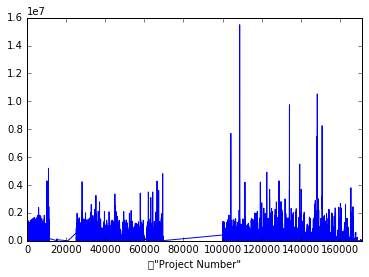

In [15]:
df["Approved Amount"].plot()

In [16]:
# Parse the dates into datetime format
df["Start Date"] = pd.to_datetime(df["Start Date"])
df["End Date"] = pd.to_datetime(df["End Date"])

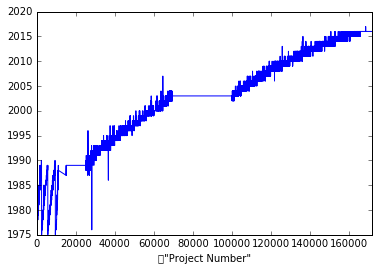

In [17]:
# Plotting the years
df["Start Date"].apply(lambda d: d.year).plot()

**From our crude analysis, we can see that the data looks inconsistent before 1990, and that the project numbering changed around 2004 but the data looks complete from 1990 to today**

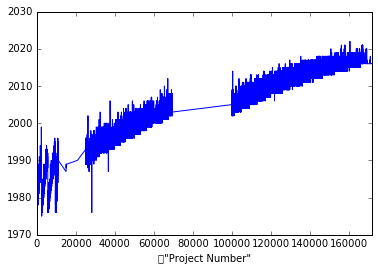

In [18]:
df["End Date"].apply(lambda d: d.year).plot()

In [19]:
df["Start Year"] = df["Start Date"].apply(lambda d: d.year)

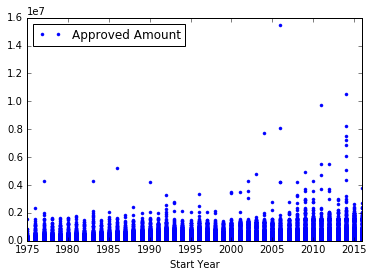

In [20]:
df.plot(x='Start Year', y='Approved Amount', style='.')

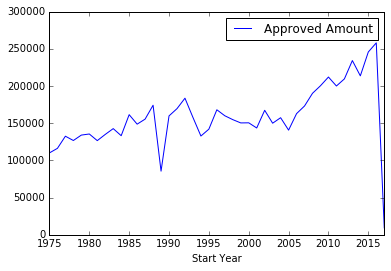

In [21]:
# Print the median amount for each year
df.groupby("Start Year").median().plot()

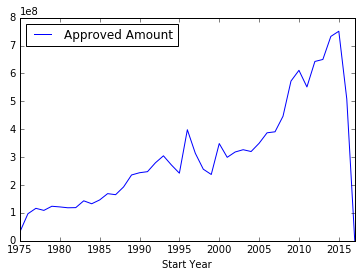

In [22]:
# Print the total of the amounts for each year
df.groupby("Start Year").sum().plot()

** We see that the yearly budget generally increases over time**

## API calls

**We want to see how much funding went to each Swiss canton. We try to find the canton for each university using the Geonames API.**

In [23]:
username = "coolestteamada"
GEO_URL = "http://api.geonames.org/searchJSON"

In [24]:
epfl_geo = requests.get(GEO_URL, params={"username": username, "q": "EPFL"})
epfl_geo.status_code

200

In [25]:
epfl_geo = epfl_geo.json()['geonames'][0]
epfl_geo

{'adminCode1': 'VD',
 'adminName1': 'Vaud',
 'countryCode': 'CH',
 'countryId': '2658434',
 'countryName': 'Switzerland',
 'fcl': 'S',
 'fclName': 'spot, building, farm',
 'fcode': 'UNIV',
 'fcodeName': 'university',
 'geonameId': 6285790,
 'lat': '46.51939',
 'lng': '6.56673',
 'name': 'Ecole Polytechnique Fédérale de Lausanne',
 'population': 0,
 'toponymName': 'Ecole Polytechnique Fédérale de Lausanne'}

**We see that the canton is returned in the 'adminCode1' field of the JSON.**

In [26]:
# seems like we can get the canton easily
epfl_geo['adminCode1']

'VD'

In [27]:
def parse_canton(json):
    """Parse the canton code from the geonames json"""
    try:
        return json['geonames'][0]['adminCode1']
    except:
        return None

In [28]:
def get_uni_canton(uni):
    """Gets the canton code given a University name, using geonames api"""
    r = requests.get(GEO_URL, params={"username": username, "q": uni})
    return parse_canton(r.json())

In [29]:
# List of all the universities
unis = list(df.groupby("University").groups.keys())
unis[0:5]

['Institut für Kulturforschung Graubünden - IKG',
 'Friedrich Miescher Institute - FMI',
 'Physikal.-Meteorolog. Observatorium Davos - PMOD',
 'Universität Bern - BE',
 'Université de Fribourg - FR']

In [30]:
# Number of different universities
len(unis)

77

**This looks like a reasonable number of calls to the geonames API. We also want to make sure we are not omitting a large amount of projects that might be taking place outside of a university (or with a missing university field).**

In [31]:
# Percentage of projects with null university field
"{0:.2f}%".format(100 * df["University"].isnull().sum() / len(df))

'4.11%'

In [32]:
# Percentage of funding with null university field
"{0:.2f}%".format(100 * df[df["University"].isnull()]["Approved Amount"].sum() / df["Approved Amount"].sum())

'0.36%'

**It is only about 4% of the projects, and 0.4% of the total fundings. So we can omit those projects without a huge loss of information**

In [33]:
# Try to get cantons for each uni
canton_dict = {}
for uni in unis:
    canton_dict[uni] = get_uni_canton(uni)

In [34]:
canton_dict.values()

dict_values([None, None, None, 'FR', None, None, None, None, None, 'NE', None, None, None, None, None, None, None, None, None, None, None, 'BS', None, None, None, None, None, None, None, None, None, 'BE', None, None, 'ZH', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None])

**Uh oh - the geonames API does not work for most of the universities. We will try filling the gaps manually. For some we cannot decide a canton, so we enter None. For multi-canton institutes or universities we assign the canton of their headquarters, if the HQ was given by the organization's website. Otherwise we also assign None.**

In [35]:
manual_canton_dict = {
    'AO Research Institute - AORI': 'GR',
    'Allergie- und Asthmaforschung - SIAF': 'GR',
    'Berner Fachhochschule - BFH': 'BE',
    'Biotechnologie Institut Thurgau - BITG': 'TG',
    "Centre de rech. sur l'environnement alpin - CREALP": 'VS',
    'EPF Lausanne - EPFL': 'VD',
    'ETH Zürich - ETHZ': 'ZH',
    'Eidg. Anstalt für Wasserversorgung - EAWAG': 'ZH',
    'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL': 'ZH',
    'Eidg. Hochschulinstitut für Berufsbildung - EHB': 'BE',
    'Eidg. Material und Prüfungsanstalt - EMPA': 'ZH',
    'Ente Ospedaliero Cantonale - EOC': 'TI',
    'Fachhochschule Kalaidos - FHKD': 'ZH',
    'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': 'SO',
    'Fachhochschule Ostschweiz - FHO': 'SG',
    'Facoltà di Teologia di Lugano - FTL': 'TI',
    'Fernfachhochschule Schweiz (Mitglied SUPSI) - FFHS': 'VS',
    'Firmen/Privatwirtschaft - FP': None,
    'Forschungsanstalten Agroscope - AGS': None, # NOTE spread across many cantons
    'Forschungsinstitut für Opthalmologie - IRO': 'VS',
    'Forschungsinstitut für biologischen Landbau - FIBL': 'AG',
    'Forschungskommission SAGW': 'BE',
    'Franklin University Switzerland - FUS': 'TI',
    'Friedrich Miescher Institute - FMI': 'BS',
    'HES de Suisse occidentale - HES-SO': None, # NOTE in Delemont but spread among 7 cantons
    'Haute école pédagogique BE, JU, NE - HEPBEJUNE': None, # NOTE no assignment; there are 3 campuses, one on each canton.
    'Haute école pédagogique du canton de Vaud - HEPL': 'VD',
    'Haute école pédagogique fribourgeoise - HEPFR': 'FR',
    'Hochschule Luzern - HSLU': 'LU',
    'Idiap Research Institute - IDIAP': 'VS',
    'Inst. Suisse de Spéléologie et Karstologie - ISSKA': 'NE',
    'Inst. de Hautes Etudes Internat. et du Dév - IHEID': 'GE',
    'Inst. universit. romand de Santé au Travail - IST': 'VD',
    'Institut Universitaire Kurt Bösch - IUKB': 'VS',
    'Institut für Kulturforschung Graubünden - IKG': 'GR',
    'Instituto Ricerche Solari Locarno - IRSOL': 'TI',
    'Interkant. Hochschule für Heilpädagogik ZH - HfH': 'ZH',
    'Istituto Svizzero di Roma - ISR': None, # NOTE in Rome, Italy!
    'Kantonsspital St. Gallen - KSPSG': 'SG',
    'NPO (Biblioth., Museen, Verwalt.) - NPO': None,
    'Nicht zuteilbar - NA': None,
    'Paul Scherrer Institut - PSI': 'AG',
    'Physikal.-Meteorolog. Observatorium Davos - PMOD': 'GR',
    'Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP': 'TI',
    'Pädagogische Hochschule Bern - PHBern': 'BE',
    'Pädagogische Hochschule Graubünden - PHGR': 'GR',
    'Pädagogische Hochschule Luzern - PHLU': 'LU',
    'Pädagogische Hochschule Nordwestschweiz - PHFHNW': 'AG',
    'Pädagogische Hochschule Schaffhausen - PHSH': 'SH',
    'Pädagogische Hochschule Schwyz - PHSZ': 'SZ',
    'Pädagogische Hochschule St. Gallen - PHSG': 'SG',
    'Pädagogische Hochschule Thurgau - PHTG': 'TG',
    'Pädagogische Hochschule Wallis - PHVS': 'VS',
    'Pädagogische Hochschule Zug - PHZG': 'ZG',
    'Pädagogische Hochschule Zürich - PHZFH': 'ZH',
    'Robert Walser-Stiftung Bern - RWS': 'BE',
    'SUP della Svizzera italiana - SUPSI': 'TI',
    'Schweiz. Hochschule für Logopädie Rorschach - SHLR': 'SG',
    'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA': 'ZH',
    'Schweizer Kompetenzzentrum Sozialwissensch. - FORS': 'VD',
    'Schweizer Paraplegiker Forschung - SPF': 'LU',
    'Staatsunabh. Theologische Hochschule Basel - STHB': 'BS',
    'Swiss Center for Electronics and Microtech. - CSEM': 'NE',
    'Swiss Institute of Bioinformatics - SIB': 'VD',
    'Università della Svizzera italiana - USI': 'TI',
    'Universität Basel - BS': 'BS', #api
    'Universität Bern - BE': 'BE', #api
    'Universität Luzern - LU': 'LU',
    'Universität St. Gallen - SG': 'SG',
    'Universität Zürich - ZH': 'ZH', #api
    'Université de Fribourg - FR': 'FR', #api
    'Université de Genève - GE': 'GE',
    'Université de Lausanne - LA': 'VD',
    'Université de Neuchâtel - NE': 'NE', #api
    'Weitere Institute - FINST': None,
    'Weitere Spitäler - ASPIT': None,
    'Zürcher Fachhochschule (ohne PH) - ZFH': 'ZH'
}

In [36]:
# We create a DataFrame from the dict
canton_df = pd.DataFrame.from_dict(manual_canton_dict, orient='index')
canton_df.columns = ['Canton']
canton_df.sample(5)

,Canton
Pädagogische Hochschule Schwyz - PHSZ,SZ
Centre de rech. sur l'environnement alpin - CREALP,VS
Haute école pédagogique fribourgeoise - HEPFR,FR
Swiss Institute of Bioinformatics - SIB,VD
Forschungsanstalten Agroscope - AGS,None


In [37]:
# And now we merge the two DataFrame to add the canton code for each project
df_with_canton = pd.merge(left=df, right=canton_df, left_on='University', right_index=True)
df_with_canton.sample(5)


,Project Title,Funding Instrument,Institution,University,Start Date,End Date,Approved Amount,Start Year,Canton
"﻿""Project Number""",,,,,,,,,
114058,The importance of local habitat fragmentation ...,Project funding (Div. I-III),Forschungsanstalt Agroscope Reckenholz-Tänikon...,Forschungsanstalten Agroscope - AGS,2006-01-12,2009-11-30,266062.0,2006.0,None
4422,Vitamin B12 und verwandte Metallkomplexe als K...,Project funding (Div. I-III),Institut für Organische Chemie Universität Bern,Universität Bern - BE,1984-01-10,1986-09-30,268860.0,1984.0,BE
135040,X-ray and Atomic Inner-Shell Processes,Project funding (Div. I-III),Département de Physique Université de Fribourg,Université de Fribourg - FR,2011-01-05,2013-04-30,337368.0,2011.0,FR
119476,Identität und Behinderung - Biografische Refle...,Publication grants,Heilpädagogisches Institut Universität Freiburg,Université de Fribourg - FR,2008-01-02,2008-02-29,3090.0,2008.0,FR
67237,Telomerase and chromosome end replication.,Project funding (Div. I-III),Institut Suisse de Recherche Expérimentale sur...,EPF Lausanne - EPFL,2002-01-04,2007-03-31,809090.0,2002.0,VD


In [38]:
# Total amount with no canton assigned
total_amt_no_canton = df_with_canton[df_with_canton['Canton'].isnull()]['Approved Amount'].sum()

# Total amount
total_amt = df_with_canton['Approved Amount'].sum()
print("{0:.2f}% of funds without a canton".format(100.0* total_amt_no_canton/total_amt))

5.21% of funds without a canton


**We see that only 5% of the funding in our table went to universities with no canton assigned. So we now drop all projects without a canton**

In [39]:
print("Len before drop: %d" % len(df_with_canton))
df_projects_with_canton = df_with_canton.dropna(subset=['Canton'])
print("Len after drop: %d" % len(df_projects_with_canton))

Len before drop: 50878
Len after drop: 45775


**We dropped roughly 5000 projects that did not have a canton. Time to make our funding map!**

In [40]:
# Now we sum the total amount assigned to each canton
funding_by_canton = df_projects_with_canton.groupby('Canton').sum()
funding_by_canton = funding_by_canton[['Approved Amount']]
funding_by_canton

,Approved Amount
Canton,
AG,1.261875e+08
BE,1.555148e+09
BS,1.392498e+09
FR,4.590737e+08
GE,1.877102e+09
GR,3.653832e+07
LU,5.467329e+07
NE,4.018976e+08
SG,9.119410e+07


In [41]:
funding_by_canton.describe()

,Approved Amount
count,1.800000e+01
mean,6.834207e+08
std,1.068527e+09
min,1.766910e+05
25%,3.136765e+07
50%,1.032282e+08
75%,1.159142e+09
max,3.700715e+09


**We see however that we have 18 cantons instead of 26. Let's fill the missing cantons and give them zero approved amounts**

In [42]:
swiss_cantons_list = ["AG", "AI", "AR", "BE", "BL", "BS", "FR", "GE", "GL", "GR", "JU", "LU", "NE", "NW", "OW", "SG", "SH", "SO", "SZ", "TG", "TI", "UR", "VD", "VS", "ZG", "ZH"]
df_all_canton = pd.DataFrame(swiss_cantons_list, columns=["Canton"])
df_all_canton['Approved Amount'] = 0
df_all_canton = df_all_canton.set_index('Canton')
df_all_canton.head()

,Approved Amount
Canton,
AG,0
AI,0
AR,0
BE,0
BL,0


**The dataframe below contains the funding total for every canton.**

In [43]:
# Add missing cantons
df_to_map = funding_by_canton.add(df_all_canton, fill_value=0)
# Also reset the index in order for folium to work (it needs a proper column)
df_to_map = df_to_map.reset_index()

In [44]:
df_to_map.head()

,Canton,Approved Amount
0,AG,1.261875e+08
1,AI,0.000000e+00
2,AR,0.000000e+00
3,BE,1.555148e+09
4,BL,0.000000e+00


** Let's test folium's choropleth with the funding total for each canton**

In [45]:
# We remove the warnings because choropleth always yields an unuseful FutureWarning
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [46]:
geo_path = 'ch-cantons.topojson.json'
    

switzerland = folium.Map(location=[46.57, 8], zoom_start=8)
switzerland.choropleth(geo_path=geo_path, 
                     data=df_to_map,
                     columns=['Canton', 'Approved Amount'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     fill_color='YlGn'
                    )
switzerland

** A few cantons (Zürich, Vaud, Geneva, and Bern) dominate the funding landscape and the rest barely show up on the Choropleth. 
We plot using a log scale for another perspective on the funding differences**

In [47]:
# Apply a log to the amounts. We add 1 to avoid negative values from the log
df_to_map['Log Approved Amount'] = np.log(df_to_map['Approved Amount'] + 1)
df_to_map.head()

,Canton,Approved Amount,Log Approved Amount
0,AG,1.261875e+08,18.653280
1,AI,0.000000e+00,0.000000
2,AR,0.000000e+00,0.000000
3,BE,1.555148e+09,21.164837
4,BL,0.000000e+00,0.000000


In [48]:
switzerland_log = folium.Map(location=[46.57, 8], zoom_start=8)
switzerland_log.choropleth(geo_path=geo_path, 
                     data=df_to_map,
                     columns=['Canton', 'Log Approved Amount'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     fill_color='YlGn'
                    )
switzerland_log

**Save these maps as HTML (for our reviewers)**

In [49]:
switzerland.save("funding_map_switzerland.html")
switzerland_log.save("funding_map_switzerland_logscale.html")

**For our reviewers: here are the links to the raw HTML files for the maps. Unfortunately the numbers overlap on the legend for 'funding_map_switzerland.html'.**
- [funding_map_switzerland](https://raw.githubusercontent.com/timozattol/ada-2016/master/hw03/funding_map_switzerland.html)
- [funding_map_switzerland_logscale](https://raw.githubusercontent.com/timozattol/ada-2016/master/hw03/funding_map_switzerland_logscale.html)

Please download them and take a look!